# Facial Detection EDA

In [2]:
#Import Libraries
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For all our visualization needs.
import cv2
import numpy as np
import statsmodels.api as sm # What does this do? Find out and type here.
from statsmodels.graphics.api import abline_plot # Useful for drawing vertical/horizontal/regression lines to a graph
from sklearn.metrics import mean_squared_error, r2_score # Metrics for measuring model accuracy
from sklearn.model_selection import train_test_split #  api that takes data to split into test training sets for statistical models
from sklearn import linear_model, preprocessing # linear regression model with preprocessing package for data streamlining
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
#set the root paths for the image directories
root_path = 'archive'
test_path = 'test'
train_path = 'train'

#set list of paths for the various facial expressions
fe_path = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#set global facial detection classifier xml
facial_detection = 'haarcascade_frontalface_default.xml'
facial_detection_side = 'lbpcascade_profileface.xml'
face_cascade = cv2.CascadeClassifier(facial_detection)
face_cascade_side = cv2.CascadeClassifier(facial_detection_side)

In [4]:
#iterate over each of the facial expression paths to get a count of the files
fe_count = dict()
for expression in fe_path:
    num = 0
    full_expression_test_path = root_path + '/' + test_path + '/' + expression
    full_expression_train_path = root_path + '/' + train_path + '/' + expression
    num += len([name for name in os.listdir(full_expression_test_path) if os.path.isfile(os.path.join(full_expression_test_path, name))])
    num += len([name for name in os.listdir(full_expression_train_path) if os.path.isfile(os.path.join(full_expression_train_path, name))])
    fe_count[expression] = num
    
print(json.dumps(fe_count, indent=4))

{
    "angry": 4953,
    "fear": 5121,
    "happy": 8989,
    "neutral": 6198,
    "sad": 6077,
    "surprise": 4002
}


In [5]:
#convert the dictionary of counts to dataframe
data_df = pd.DataFrame(fe_count.items(), columns=['Expression', 'Count'])
data_df.head(7)

,Expression,Count
0,angry,4953
1,fear,5121
2,happy,8989
3,neutral,6198
4,sad,6077
5,surprise,4002


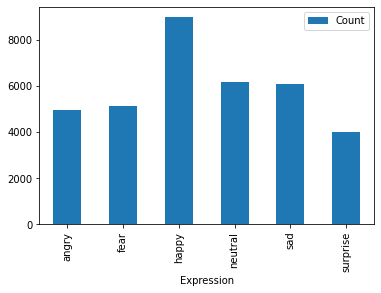

In [7]:
data_df.plot.bar(x='Expression', y='Count')
plt.show()

# Data Inconsistencies

There appears to be an inbalance in the data provided for this capstone. Specifically the expression disgust only has 547 images in the repo, while the next lowest is surprise at 4002, making it only 13.7% of the next smallest grouping of photos. This can be addressed multiple ways:
1. Disregard the entire data set for disgust facial expressions
2. Make all the data equal by having each facial expression data be no more than 600 images
3. Find additional images to put under the category of disgust

After consideration it was decided that disgust facial expression should be excluded from the training of the project and tests will be done to test accuracy based on the six other facial expressions

# View Sample of Data from Different Facial Expression Categories

Let's check the images in our training set and use opencv's face detection api to get bounding boxes around each of the images.

In [6]:
def detect_face(img_path, return_face=False):
    img = cv2.imread(img_path)
    faces = face_cascade.detectMultiScale(img, 1.05, 1)

    if len(faces) == 0:
        faces = face_cascade_side.detectMultiScale(img, 1.05, 1)

    if len(faces) == 0:
        return False

    if return_face:
        return faces
    
    return True

In [7]:
#Create function that will display images based on file path as a parameter along with a 
#parameter that signifies how many images to display for each type of facial expression
def plot_images(img_dir, expression, top=10):
    faces = None
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:top]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(expression, fontsize=20)
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)

        img = cv2.imread(img_path)

        faces = face_cascade.detectMultiScale(img, 1.05, 1)

        if len(faces) == 0:
            faces = face_cascade_side.detectMultiScale(img, 1.05, 1)

        # Draw rectangle around the faces
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
        
        plt.tight_layout()         
        plt.imshow(img, cmap='gray')

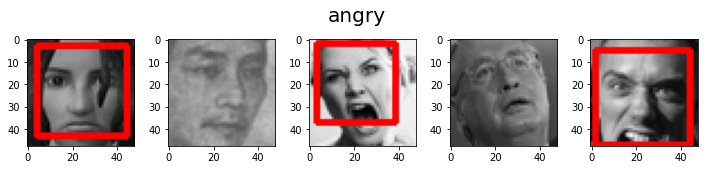

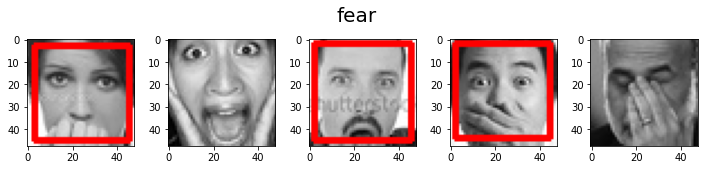

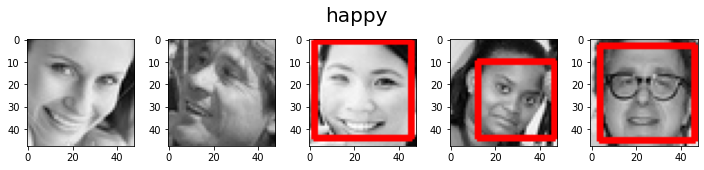

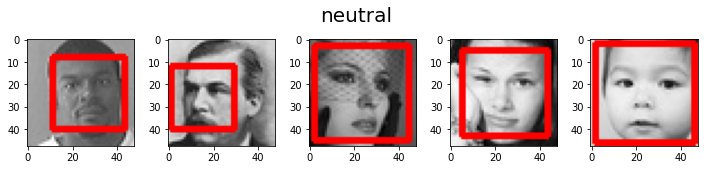

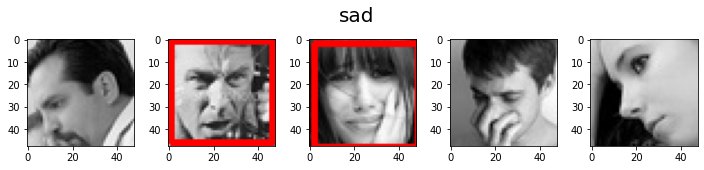

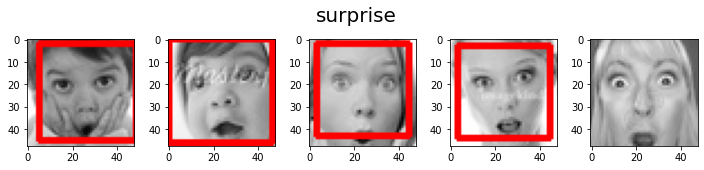

In [11]:
#Invoke the function to display images for each facial expression type
for expression in fe_path:
    full_expression_test_path = root_path + '/' + test_path + '/' + expression
    plot_images(full_expression_test_path, expression, top=5)

*It appears that not all the images in the photos are being picked up. Let's see what percentage of images for each category are actually getting a face detected in the photos' used in the training set.*

In [8]:
#Create function that will display images based on file path as a parameter along with a 
#parameter that signifies how many images to display for each type of facial expression
def check_images(img_dir, expression, top=10):
    faces = None
    all_img_dirs = os.listdir(img_dir)
    count = 0
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs]
    for idx, img_path in enumerate(img_files):
        if detect_face(img_path):
            count += 1        
    return count/len(img_files)

In [8]:
#Invoke the function to display images for each facial expression type
for expression in fe_path:
    full_expression_train_path = root_path + '/' + train_path + '/' + expression
    num_expression = check_images(full_expression_train_path, expression)
    print(expression, num_expression)

angry 0.6217772215269086
fear 0.5809128630705395
happy 0.6835758835758836
neutral 0.7196374622356495
sad 0.5014492753623189
surprise 0.6985178177231157


*In the worst case it appears that ~50% of the data in the training set is not accounted for specifically for the 'sadness' expression data. In the best case we see neutral having the least missing facial detection at ~29%. Is this an issue? Limited amount of data may lead to a stronger bias in the training for the different classifications.*

# DLib for Facial feature detection 
*Let's use the Dlib library to detect the facial features in the training images*

In [9]:
import dlib
# Load the detector
detector = dlib.get_frontal_face_detector()
# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [10]:
def detect_face_dlib(img_path, return_face=False):
    img = cv2.imread(img_path)
    #resize image
    scale_percent = 900
    scale_width = int(img.shape[1] * scale_percent/100)
    scale_height = int(img.shape[0] * scale_percent/100)
    dim = (scale_width, scale_height)
    resize_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # Convert image into grayscale
    gray = cv2.cvtColor(src=resize_img, code=cv2.COLOR_BGR2GRAY)
    # Use detector to find landmarks
    faces = detector(gray)

    if return_face and len(faces) > 0:
        face_data = {}
        face_data['faces'] = faces
        face_data['resize_img'] = resize_img
        return face_data
    else:
        if len(faces) > 0:
            return True

        return False

    # return False



In [11]:
#Create function that will display images based on file path as a parameter along with a 
def plot_dlib_images(img_dir, expression, top=10, show_image=True):
#parameter that signifies how many images to display for each type of facial expression
    faces = None
    all_img_dirs = os.listdir(img_dir)
    count = 0
    # img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:top]
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(expression, fontsize=20)
    for idx, img_path in enumerate(img_files):
        
        if count >= top:
            return True

        if detect_face_dlib(img_path):
            plt.subplot(5, 5, count+1)
            count += 1
            img = cv2.imread(img_path)
            #resize image
            scale_percent = 900
            scale_width = int(img.shape[1] * scale_percent/100)
            scale_height = int(img.shape[0] * scale_percent/100)
            dim = (scale_width, scale_height)
            resize_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            # Convert image into grayscale
            gray = cv2.cvtColor(src=resize_img, code=cv2.COLOR_BGR2GRAY)
            # Use detector to find landmarks
            faces = detector(gray)
            for face in faces:
                x1 = face.left() # left point
                y1 = face.top() # top point
                x2 = face.right() # right point
                y2 = face.bottom() # bottom point
                # Look for the landmarks
                landmarks = predictor(image=gray, box=face)

                #create white img
                img_white = np.zeros([400, 400, 1], dtype=np.uint8)
                img_white.fill(255)
                # Loop through all the points
                for n in range(0, 68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    # Draw a circle
                    if show_image:
                        cv2.circle(img=resize_img, center=(x, y), radius=5, color=(0, 255, 0), thickness=-1)
                    else:
                        cv2.circle(img=img_white, center=(x, y), radius=5, color=(0, 255, 0), thickness=-1)
            # plt.tight_layout()
            if show_image:
                plt.imshow(resize_img, cmap='gray')
                plt.tight_layout()
            else:
                plt.imshow(img_white, cmap='gray')
                plt.tight_layout()

    


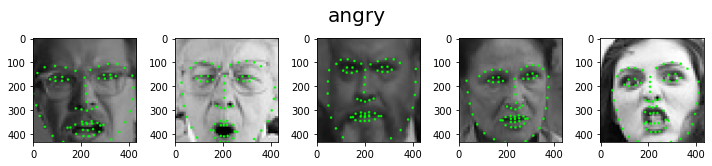

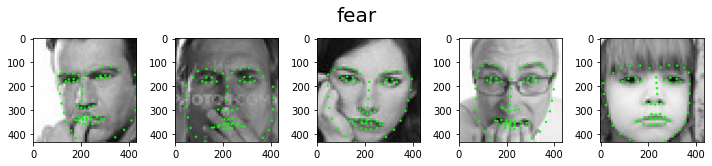

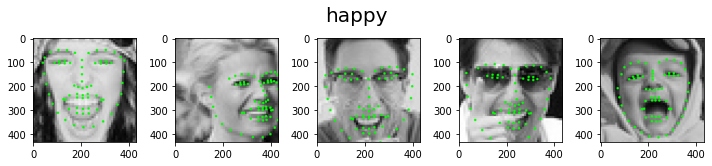

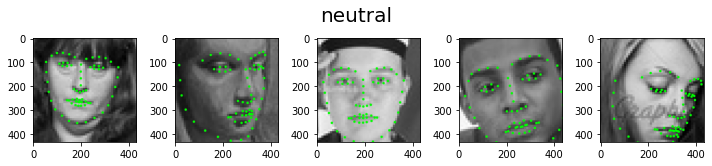

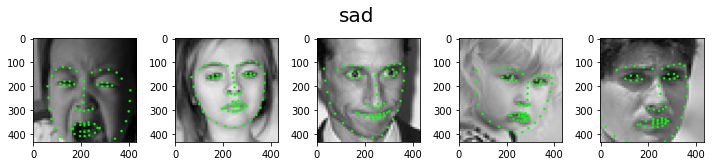

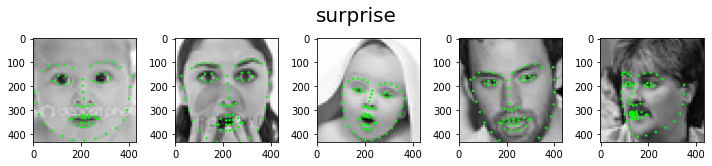

In [12]:


for expression in fe_path:
    full_expression_train_path = root_path + '/' + train_path + '/' + expression
    plot_dlib_images(full_expression_train_path, expression, top=5, show_image=True)


*Interesting! By visually observing the data from the image plots, the landmark patterns on the images appears some expressions are more visibly obvious than others. Let's do some exploration on these landmarks for the various facial features. We can even see with one of the images for surprise has the facial landmarks detected incorrectly. However, for most of the other pictures we see so far its fair to say that faces have been correctly detected*

*Can we look at these landmarks again and see if they facial expressions are clearly visible using just the landmarks without the image in the backgrond. Let's try that out!*

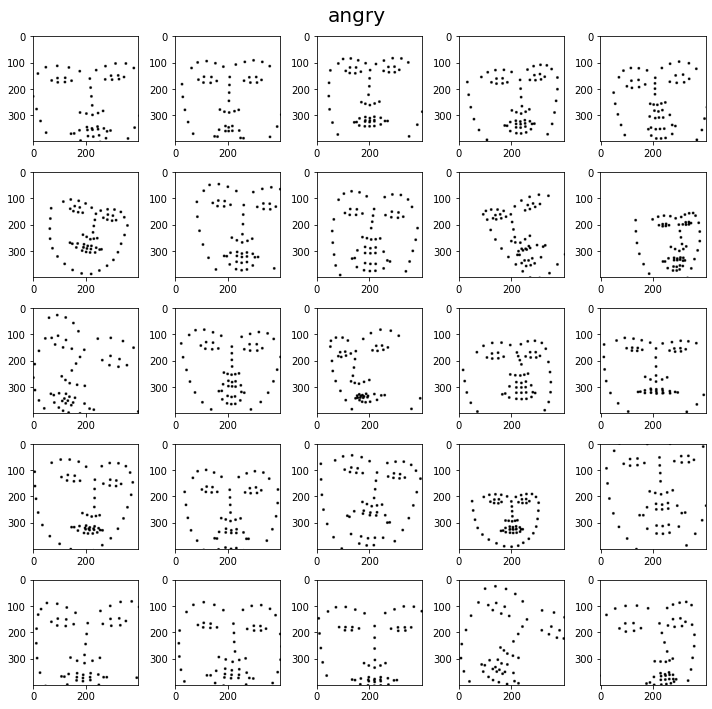

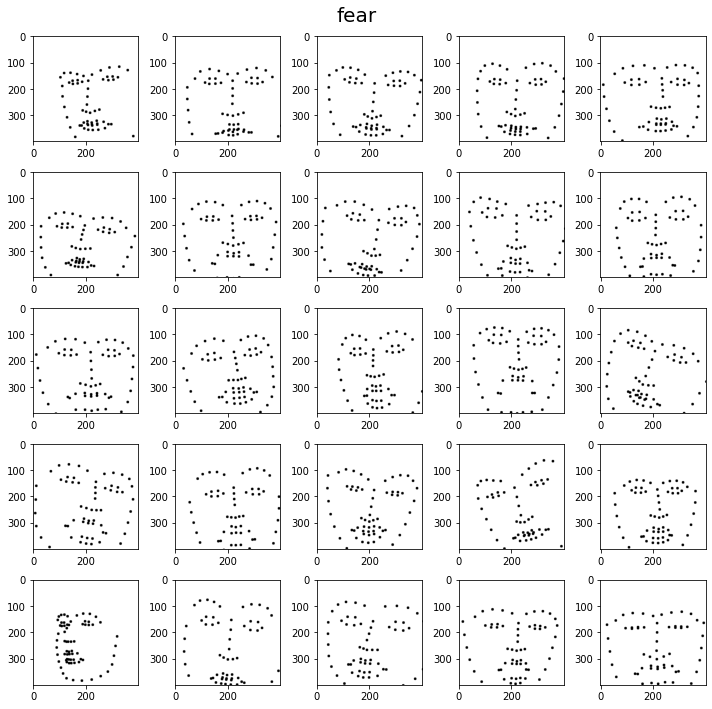

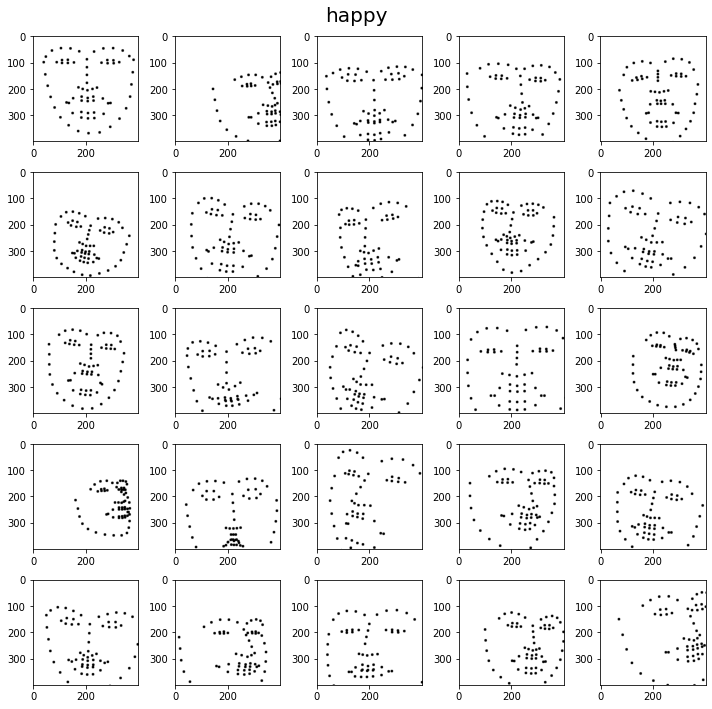

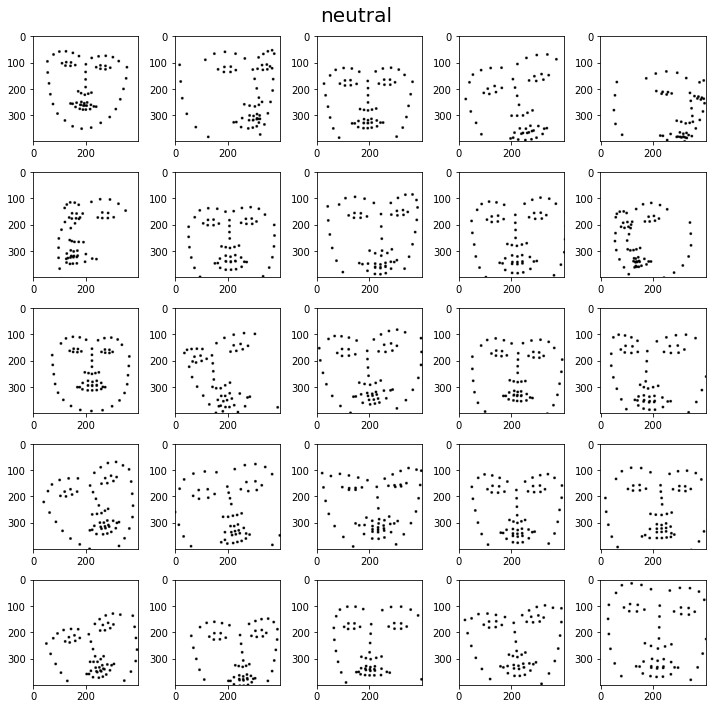

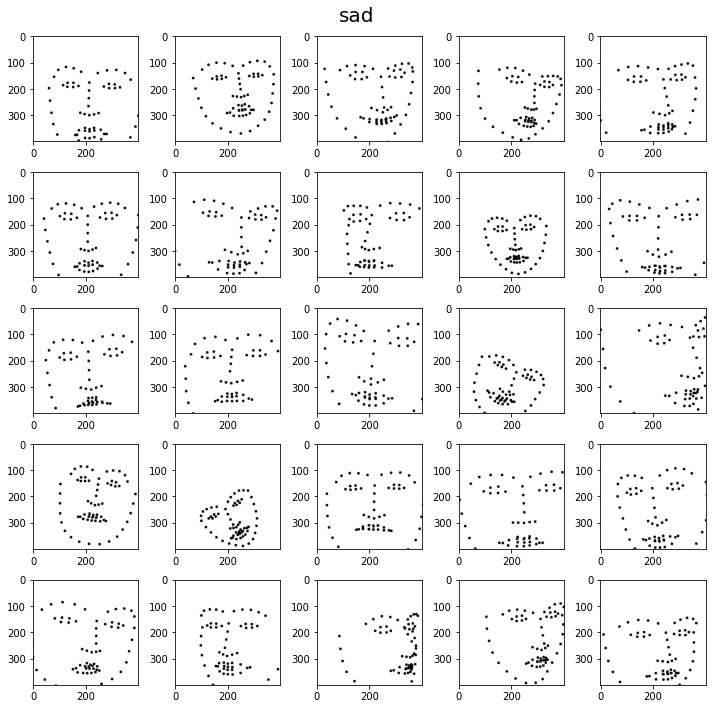

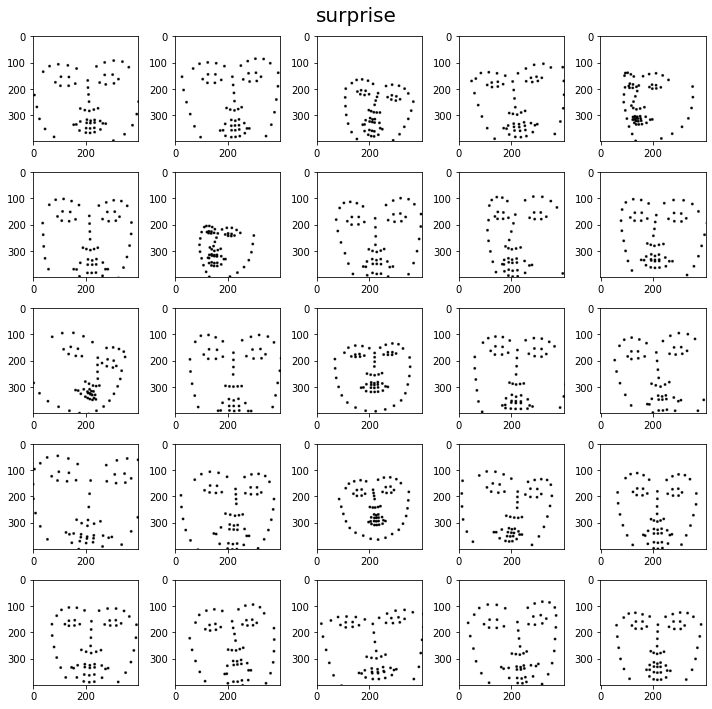

In [13]:
for expression in fe_path:
    full_expression_train_path = root_path + '/' + train_path + '/' + expression
    plot_dlib_images(full_expression_train_path, expression, top=25, show_image=False)

*From the looks of the data using the human eye the expression that easiest to discern the expression using landmarks is happy. The others could are not that easily distinguishable. Perhaps the scope of the project should be adjusted. Detect whether a person is happy or not. A classifer with two states (happy, not happy).*

# Initial Hypothesis for the Data

*Going in the direction of detecting happiness for a person, there is a pattern in the facial featues (specifically the mouth) that denotes an assumption we can make about happy people. Generally speaking people who are visibly happy show this expression when their mouths lift at the corners creating a curve similiar to a parabola. Let's see if we can further explore this hypothesis* 

*According to the dlib libary, landmark the following landmark points are for the mouth (specifically bottom of the upper lip to the corners):*

*Corners of lip (49, 55)*

*Bottom of top lip (61 - 65)*


In [13]:
def get_landmark_slope():
    img_data = []
    for expression in fe_path:
        full_expression_train_path = root_path + '/' + train_path + '/' + expression
        faces = None
        all_img_dirs = os.listdir(full_expression_train_path)
        count = 0
        img_files = [os.path.join(full_expression_train_path, file) for file in all_img_dirs][:100]
        for idx, img_path in enumerate(img_files):
            face_data_return = detect_face_dlib(img_path,True)
            if face_data_return:
                resize_img = face_data_return['resize_img']
                gray = cv2.cvtColor(src=resize_img, code=cv2.COLOR_BGR2GRAY)
                for face in face_data_return['faces']:
                    # Look for the landmarks
                    landmarks = predictor(image=gray, box=face)
                    face_data = {}
                    # Loop through all the points
                    left_corner_x = landmarks.part(49).x
                    left_corner_y = landmarks.part(49).y
                    left_corner_x1 = landmarks.part(61).x
                    left_corner_y1 = landmarks.part(61).y
                    right_corner_x = landmarks.part(55).x
                    right_corner_y = landmarks.part(55).y
                    right_corner_x1 = landmarks.part(65).x
                    right_corner_y1 = landmarks.part(65).y
                    # left_slope = (left_corner_y - left_corner_y1)/(left_corner_x - left_corner_x1) if left_corner_x - left_corner_x1 > 0 else 0
                    # right_slope = (right_corner_y1 - right_corner_y)/(right_corner_x1 - right_corner_x) if right_corner_x1 - right_corner_x > 0 else 0
                    face_data['img_path'] = img_data
                    face_data['left_corner_x'] = left_corner_x
                    face_data['left_corner_x1'] = left_corner_x1
                    face_data['right_corner_x'] = right_corner_x
                    face_data['right_corner_x1'] = right_corner_x1
                    face_data['right_corner_y'] = right_corner_y
                    face_data['right_corner_y1'] = right_corner_y1
                    face_data['left_corner_y'] = left_corner_y
                    face_data['left_corner_y1'] = left_corner_y1
                    face_data['width'] = face.width()
                    face_data['height'] = face.height()
                    face_data['expression'] = expression
                    face_data['landmarks'] = landmarks
                    
                    # face_data['left_slope'] = left_slope
                    # face_data['right_slope'] = right_slope
                    # print(face_data)
                    img_data.append(face_data)

    return pd.DataFrame(img_data)

In [14]:
img_data_df = get_landmark_slope()
img_data_df.head()

,img_path,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,width,height,expression,landmarks
0,"[{'img_path': [{'img_path': [{...}, {'img_path...",175,205,275,249,389,378,359,358,496,447,angry,<_dlib_pybind11.full_object_detection object a...
1,"[{'img_path': [{'img_path': [{...}, {'img_path...",166,190,242,218,416,406,357,362,496,447,angry,<_dlib_pybind11.full_object_detection object a...
2,"[{'img_path': [{'img_path': [{...}, {'img_path...",160,182,240,216,337,325,314,322,373,373,angry,<_dlib_pybind11.full_object_detection object a...
3,"[{'img_path': [{'img_path': [{...}, {'img_path...",193,215,271,250,355,345,328,335,373,373,angry,<_dlib_pybind11.full_object_detection object a...
4,"[{'img_path': [{'img_path': [{...}, {'img_path...",187,208,272,242,373,353,307,313,373,373,angry,<_dlib_pybind11.full_object_detection object a...


*Now that we have the image data in a data frame processed by dlib and opencv let's go ahead and test out our insert additional columns to keep track of the slope for the right and left corners of the mouth identified.*

In [15]:
img_data_df['right_slope'] = (img_data_df['right_corner_y1'] - img_data_df['right_corner_y'])/(img_data_df['right_corner_x1'] - img_data_df['right_corner_x'])
img_data_df['left_slope'] = (img_data_df['left_corner_y'] - img_data_df['left_corner_y1'])/(img_data_df['left_corner_x'] - img_data_df['left_corner_x1'])
img_data_df['area'] = img_data_df['width'] * img_data_df['height']

In [16]:
img_data_df.head()

,img_path,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,width,height,expression,landmarks,right_slope,left_slope,area
0,"[{'img_path': [{'img_path': [{...}, {'img_path...",175,205,275,249,389,378,359,358,496,447,angry,<_dlib_pybind11.full_object_detection object a...,0.423077,-0.033333,221712
1,"[{'img_path': [{'img_path': [{...}, {'img_path...",166,190,242,218,416,406,357,362,496,447,angry,<_dlib_pybind11.full_object_detection object a...,0.416667,0.208333,221712
2,"[{'img_path': [{'img_path': [{...}, {'img_path...",160,182,240,216,337,325,314,322,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.500000,0.363636,139129
3,"[{'img_path': [{'img_path': [{...}, {'img_path...",193,215,271,250,355,345,328,335,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.476190,0.318182,139129
4,"[{'img_path': [{'img_path': [{...}, {'img_path...",187,208,272,242,373,353,307,313,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.666667,0.285714,139129


*Let's take a look at the data and see rows pertaining to the happy expression*

In [22]:
img_data_df[img_data_df['expression'] == 'happy']

,img_path,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,expression,right_slope,left_slope
131,"[{'img_path': [{'img_path': [{...}, {'img_path...",151,183,266,230,297,292,238,247,happy,0.138889,0.281250
132,"[{'img_path': [{'img_path': [{...}, {'img_path...",314,347,396,378,327,324,295,298,happy,0.166667,0.090909
133,"[{'img_path': [{'img_path': [{...}, {'img_path...",163,193,271,238,367,370,324,330,happy,-0.090909,0.200000
134,"[{'img_path': [{'img_path': [{...}, {'img_path...",173,207,277,249,357,349,299,311,happy,0.285714,0.352941
135,"[{'img_path': [{'img_path': [{...}, {'img_path...",189,216,277,247,331,326,261,259,happy,0.166667,-0.074074
...,...,...,...,...,...,...,...,...,...,...,...,...
208,"[{'img_path': [{'img_path': [{...}, {'img_path...",158,193,276,240,401,399,321,324,happy,0.055556,0.085714
209,"[{'img_path': [{'img_path': [{...}, {'img_path...",177,212,293,261,363,358,335,338,happy,0.156250,0.085714
210,"[{'img_path': [{'img_path': [{...}, {'img_path...",150,173,242,213,311,306,301,309,happy,0.172414,0.347826
211,"[{'img_path': [{'img_path': [{...}, {'img_path...",119,144,217,186,322,313,259,268,happy,0.290323,0.360000


In [17]:
#Add additional column that adds both left and right slope together
img_data_df['slope_total'] = img_data_df['right_slope'] + img_data_df['left_slope']
img_data_df['slope_prop_total'] = img_data_df['slope_total'] / img_data_df['area']
img_data_df.head()

,img_path,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,width,height,expression,landmarks,right_slope,left_slope,area,slope_total,slope_prop_total
0,"[{'img_path': [{'img_path': [{...}, {'img_path...",175,205,275,249,389,378,359,358,496,447,angry,<_dlib_pybind11.full_object_detection object a...,0.423077,-0.033333,221712,0.389744,0.000002
1,"[{'img_path': [{'img_path': [{...}, {'img_path...",166,190,242,218,416,406,357,362,496,447,angry,<_dlib_pybind11.full_object_detection object a...,0.416667,0.208333,221712,0.625000,0.000003
2,"[{'img_path': [{'img_path': [{...}, {'img_path...",160,182,240,216,337,325,314,322,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.500000,0.363636,139129,0.863636,0.000006
3,"[{'img_path': [{'img_path': [{...}, {'img_path...",193,215,271,250,355,345,328,335,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.476190,0.318182,139129,0.794372,0.000006
4,"[{'img_path': [{'img_path': [{...}, {'img_path...",187,208,272,242,373,353,307,313,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.666667,0.285714,139129,0.952381,0.000007


# Image Data Correlations

**Let's look column correlations using pandas corr() feature**

In [18]:
img_data_df.corr()

,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,width,height,right_slope,left_slope,area,slope_total,slope_prop_total
left_corner_x,1.000000,0.983573,0.846210,0.923931,-0.193355,-0.141295,0.075544,-0.001108,-0.196727,-0.107518,0.094015,-0.461871,-0.156241,-0.020460,0.023170
left_corner_x1,0.983573,1.000000,0.906653,0.969882,-0.132383,-0.071544,0.075149,0.002456,-0.127628,-0.029148,0.078118,-0.512342,-0.085652,-0.047016,-0.028941
right_corner_x,0.846210,0.906653,1.000000,0.976619,-0.013399,0.067693,0.131119,0.064833,0.065490,0.165551,-0.085983,-0.567403,0.101196,-0.212370,-0.250435
right_corner_x1,0.923931,0.969882,0.976619,1.000000,-0.066929,0.002601,0.113554,0.047257,-0.014080,0.086940,0.003207,-0.545001,0.025619,-0.124255,-0.139905
right_corner_y,-0.193355,-0.132383,-0.013399,-0.066929,1.000000,0.964625,0.714764,0.727962,0.427012,0.426943,0.057212,-0.013202,0.403619,0.050085,-0.100827
right_corner_y1,-0.141295,-0.071544,0.067693,0.002601,0.964625,1.000000,0.662196,0.650148,0.345922,0.351922,-0.043516,-0.158687,0.325009,-0.077487,-0.202078
left_corner_y,0.075544,0.075149,0.131119,0.113554,0.714764,0.662196,1.000000,0.983490,0.390779,0.370252,0.106461,-0.057444,0.366853,0.085523,-0.050550
left_corner_y1,-0.001108,0.002456,0.064833,0.047257,0.727962,0.650148,0.983490,1.000000,0.424271,0.397893,0.140207,0.092203,0.398047,0.151820,0.007480
width,-0.196727,-0.127628,0.065490,-0.014080,0.427012,0.345922,0.390779,0.424271,1.000000,0.965791,0.037990,0.055658,0.990215,0.048298,-0.231909
height,-0.107518,-0.029148,0.165551,0.086940,0.426943,0.351922,0.370252,0.397893,0.965791,1.000000,0.036557,-0.003147,0.981529,0.033238,-0.248507


*Let's convert the expression in the dataframe to be categorical*

In [19]:
img_data_df['expression_code'] = img_data_df['expression'].astype("category").cat.codes
img_data_df.head()

,img_path,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,width,height,expression,landmarks,right_slope,left_slope,area,slope_total,slope_prop_total,expression_code
0,"[{'img_path': [{'img_path': [{...}, {'img_path...",175,205,275,249,389,378,359,358,496,447,angry,<_dlib_pybind11.full_object_detection object a...,0.423077,-0.033333,221712,0.389744,0.000002,0
1,"[{'img_path': [{'img_path': [{...}, {'img_path...",166,190,242,218,416,406,357,362,496,447,angry,<_dlib_pybind11.full_object_detection object a...,0.416667,0.208333,221712,0.625000,0.000003,0
2,"[{'img_path': [{'img_path': [{...}, {'img_path...",160,182,240,216,337,325,314,322,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.500000,0.363636,139129,0.863636,0.000006,0
3,"[{'img_path': [{'img_path': [{...}, {'img_path...",193,215,271,250,355,345,328,335,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.476190,0.318182,139129,0.794372,0.000006,0
4,"[{'img_path': [{'img_path': [{...}, {'img_path...",187,208,272,242,373,353,307,313,373,373,angry,<_dlib_pybind11.full_object_detection object a...,0.666667,0.285714,139129,0.952381,0.000007,0


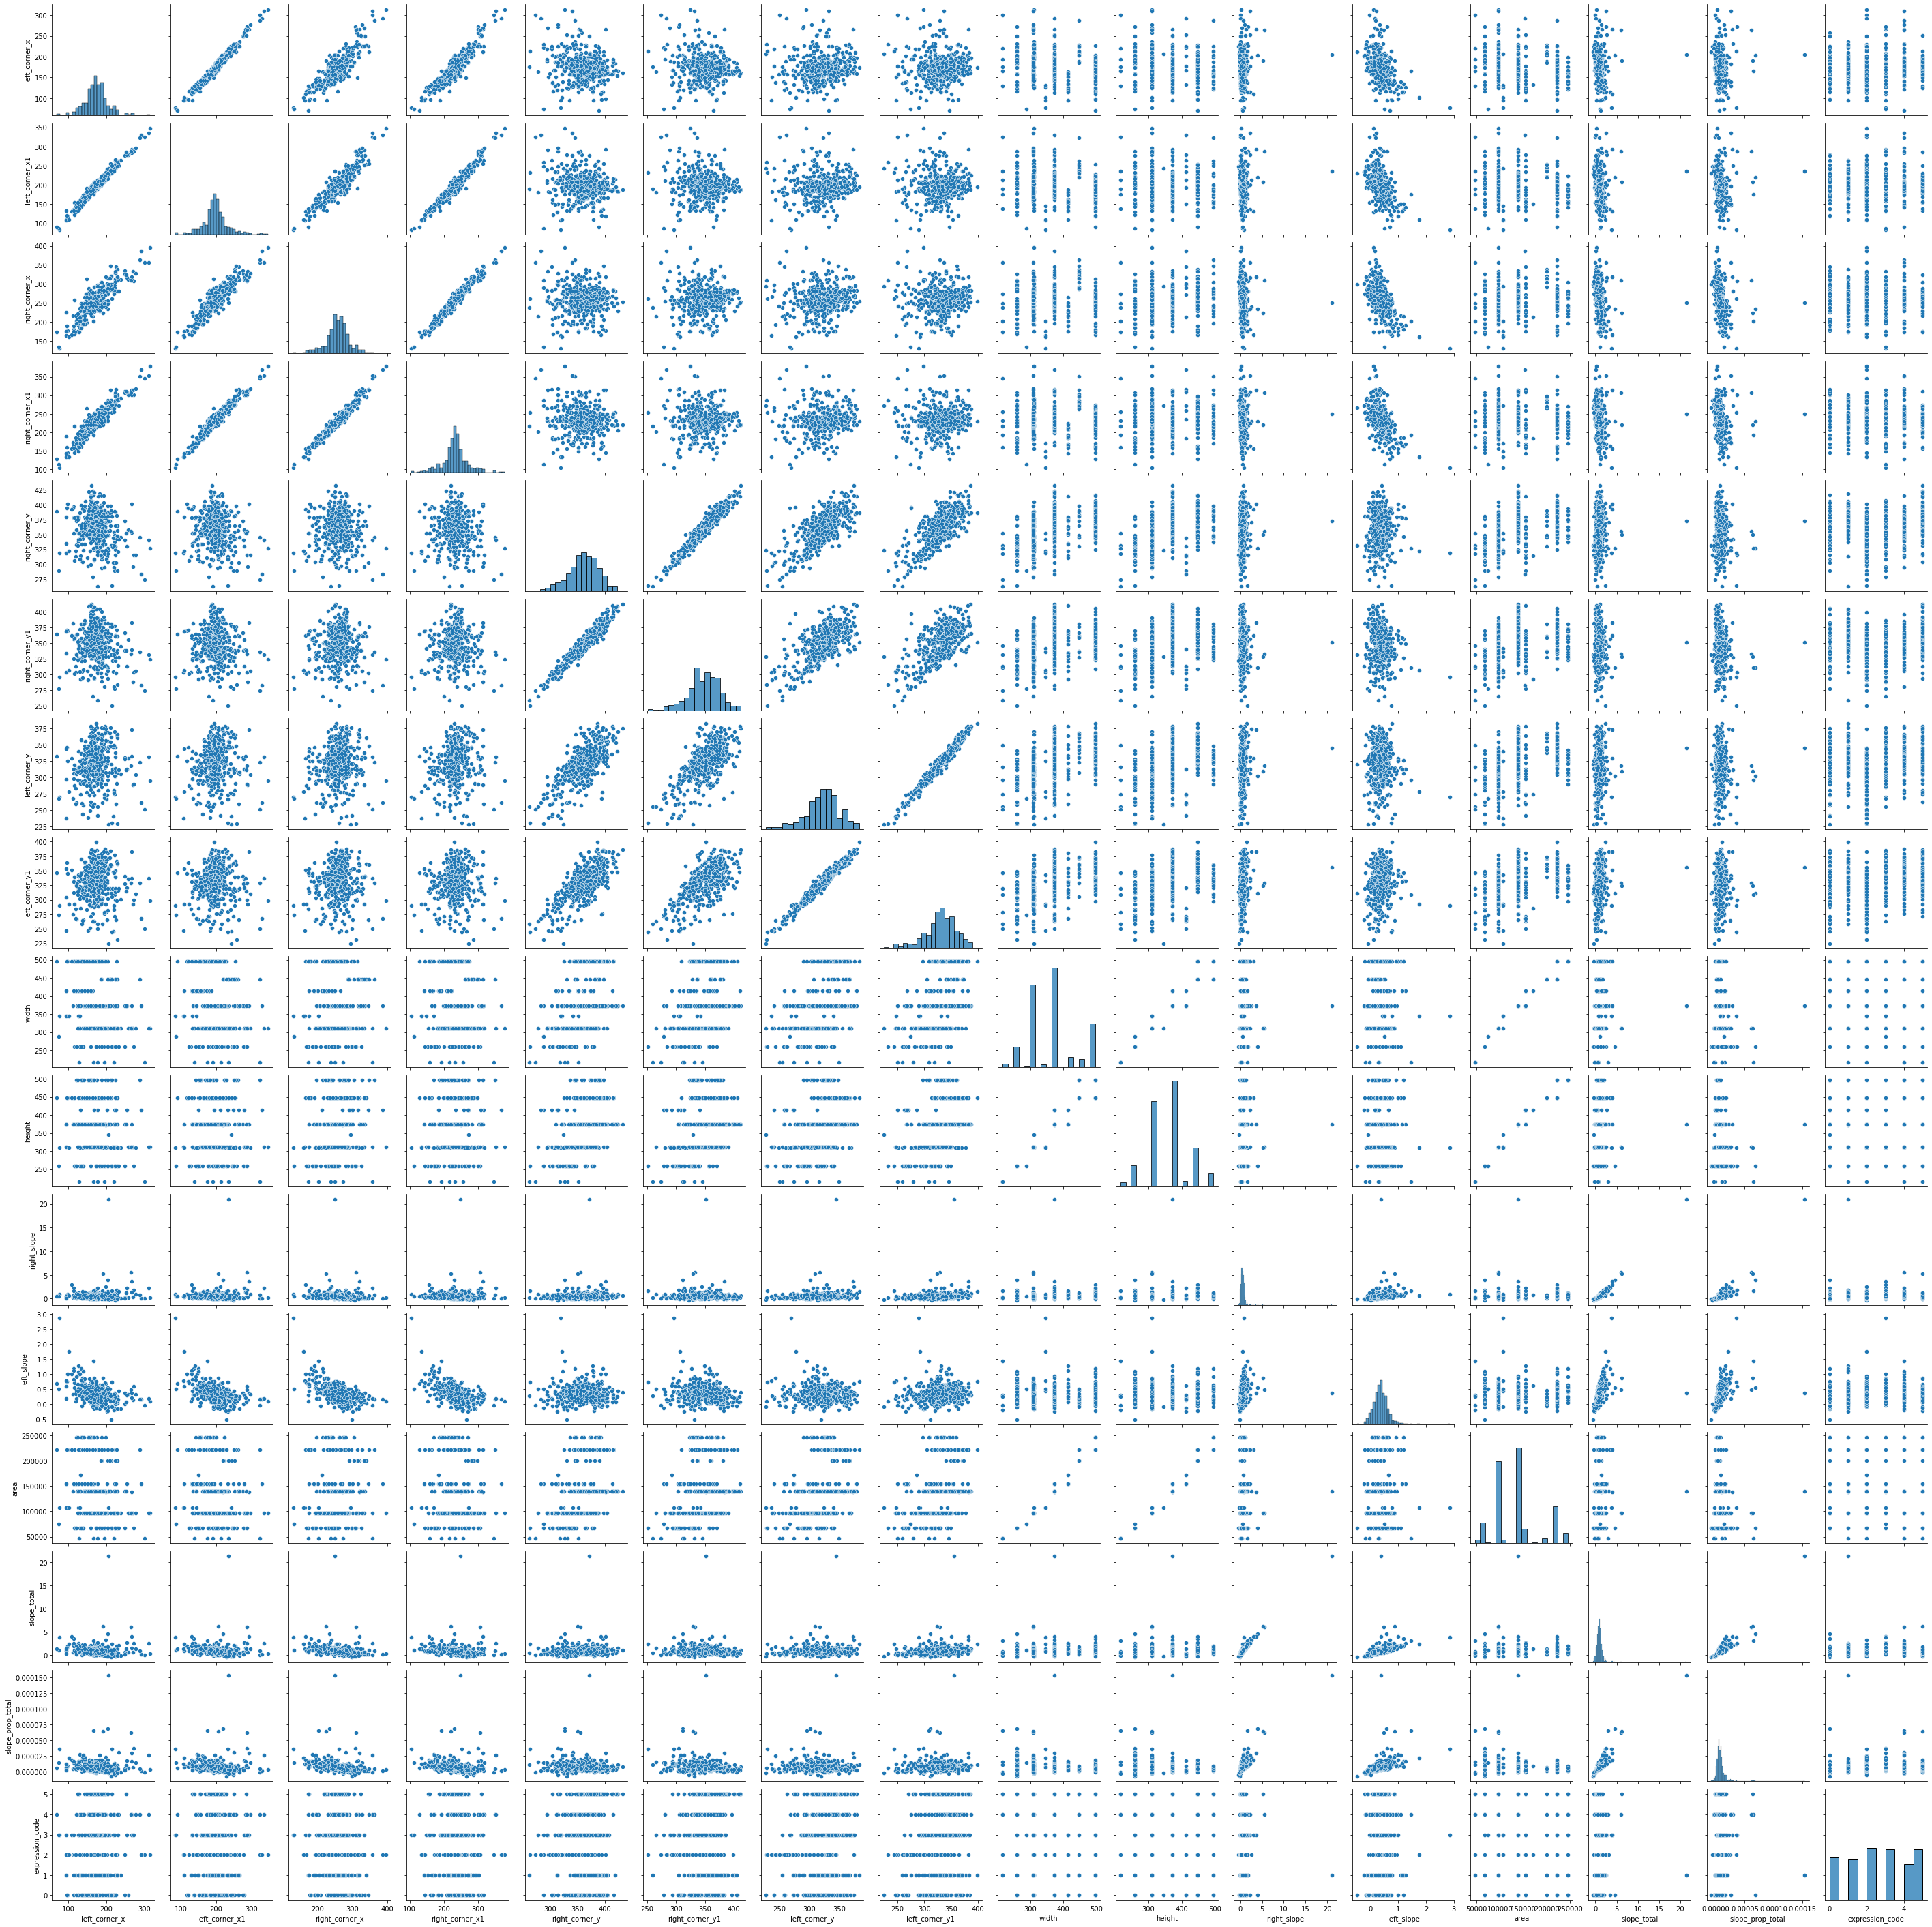

In [22]:
#visualizing the correlation
_ = sns.pairplot(img_data_df)

*Looking at these plots there seems to be some data that has strong correlation between each other let's see if we can view these correlations using a heatmap*

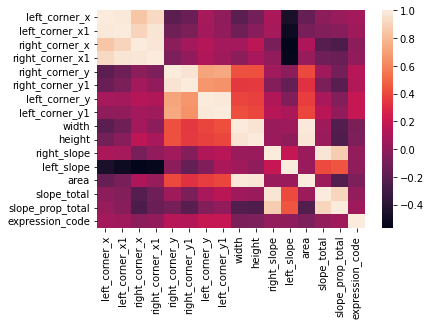

In [23]:
_ = sns.heatmap(img_data_df.corr())

<AxesSubplot:xlabel='expression', ylabel='slope_prop_total'>

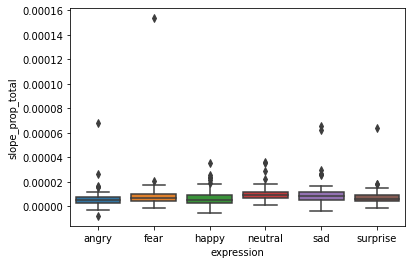

In [24]:
sns.boxplot(x='expression', y='slope_prop_total', data=img_data_df)

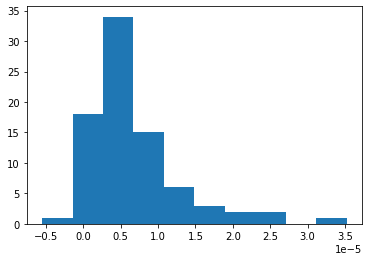

In [25]:
_ = plt.hist(img_data_df[img_data_df['expression'] == 'happy']['slope_prop_total'])
plt.show()

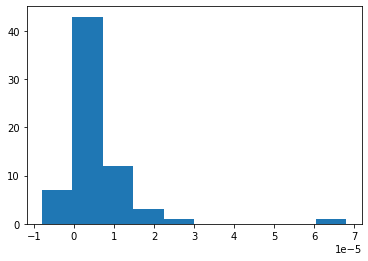

In [26]:
_ = plt.hist(img_data_df[img_data_df['expression'] == 'angry']['slope_prop_total'])
plt.show()

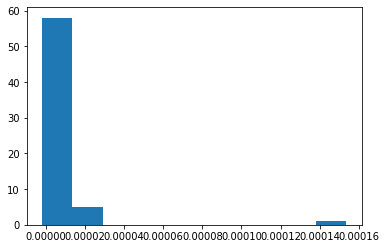

In [27]:
_ = plt.hist(img_data_df[img_data_df['expression'] == 'fear']['slope_prop_total'])
plt.show()

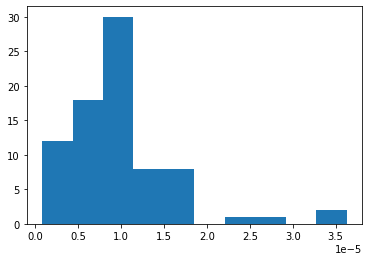

In [28]:
_ = plt.hist(img_data_df[img_data_df['expression'] == 'neutral']['slope_prop_total'])
plt.show()

In [20]:
#lets update the data frame to create two categories for expressions (happy and not happy)
img_data_df_new = img_data_df
img_data_df_new.loc[img_data_df_new['expression'] != 'happy', 'expression'] = 'non_happy'
img_data_df_new['expression_code'] = img_data_df_new['expression'].astype('category').cat.codes
img_data_df_new

,img_path,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,width,height,expression,landmarks,right_slope,left_slope,area,slope_total,slope_prop_total,expression_code
0,"[{'img_path': [{'img_path': [{...}, {'img_path...",175,205,275,249,389,378,359,358,496,447,non_happy,<_dlib_pybind11.full_object_detection object a...,0.423077,-0.033333,221712,0.389744,0.000002,1
1,"[{'img_path': [{'img_path': [{...}, {'img_path...",166,190,242,218,416,406,357,362,496,447,non_happy,<_dlib_pybind11.full_object_detection object a...,0.416667,0.208333,221712,0.625000,0.000003,1
2,"[{'img_path': [{'img_path': [{...}, {'img_path...",160,182,240,216,337,325,314,322,373,373,non_happy,<_dlib_pybind11.full_object_detection object a...,0.500000,0.363636,139129,0.863636,0.000006,1
3,"[{'img_path': [{'img_path': [{...}, {'img_path...",193,215,271,250,355,345,328,335,373,373,non_happy,<_dlib_pybind11.full_object_detection object a...,0.476190,0.318182,139129,0.794372,0.000006,1
4,"[{'img_path': [{'img_path': [{...}, {'img_path...",187,208,272,242,373,353,307,313,373,373,non_happy,<_dlib_pybind11.full_object_detection object a...,0.666667,0.285714,139129,0.952381,0.000007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,"[{'img_path': [{'img_path': [{...}, {'img_path...",185,209,257,234,374,361,331,334,310,311,non_happy,<_dlib_pybind11.full_object_detection object a...,0.565217,0.125000,96410,0.690217,0.000007,1
426,"[{'img_path': [{'img_path': [{...}, {'img_path...",158,185,250,221,412,392,336,348,373,373,non_happy,<_dlib_pybind11.full_object_detection object a...,0.689655,0.444444,139129,1.134100,0.000008,1
427,"[{'img_path': [{'img_path': [{...}, {'img_path...",191,213,263,241,384,375,344,352,373,373,non_happy,<_dlib_pybind11.full_object_detection object a...,0.409091,0.363636,139129,0.772727,0.000006,1
428,"[{'img_path': [{'img_path': [{...}, {'img_path...",187,202,240,225,380,370,341,349,259,259,non_happy,<_dlib_pybind11.full_object_detection object a...,0.666667,0.533333,67081,1.200000,0.000018,1


In [37]:
img_data_df_new[img_data_df_new['expression'] == 'happy']

,img_path,left_corner_x,left_corner_x1,right_corner_x,right_corner_x1,right_corner_y,right_corner_y1,left_corner_y,left_corner_y1,width,height,expression,landmarks,right_slope,left_slope,area,slope_total,slope_prop_total,expression_code
131,"[{'img_path': [{'img_path': [{...}, {'img_path...",151,183,266,230,297,292,238,247,310,311,happy,<_dlib_pybind11.full_object_detection object a...,0.138889,0.281250,96410,0.420139,4.357835e-06,0
132,"[{'img_path': [{'img_path': [{...}, {'img_path...",314,347,396,378,327,324,295,298,311,311,happy,<_dlib_pybind11.full_object_detection object a...,0.166667,0.090909,96721,0.257576,2.663080e-06,0
133,"[{'img_path': [{'img_path': [{...}, {'img_path...",163,193,271,238,367,370,324,330,373,373,happy,<_dlib_pybind11.full_object_detection object a...,-0.090909,0.200000,139129,0.109091,7.840990e-07,0
134,"[{'img_path': [{'img_path': [{...}, {'img_path...",173,207,277,249,357,349,299,311,373,373,happy,<_dlib_pybind11.full_object_detection object a...,0.285714,0.352941,139129,0.638655,4.590383e-06,0
135,"[{'img_path': [{'img_path': [{...}, {'img_path...",189,216,277,247,331,326,261,259,310,310,happy,<_dlib_pybind11.full_object_detection object a...,0.166667,-0.074074,96100,0.092593,9.635025e-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,"[{'img_path': [{'img_path': [{...}, {'img_path...",158,193,276,240,401,399,321,324,373,373,happy,<_dlib_pybind11.full_object_detection object a...,0.055556,0.085714,139129,0.141270,1.015387e-06,0
209,"[{'img_path': [{'img_path': [{...}, {'img_path...",177,212,293,261,363,358,335,338,373,373,happy,<_dlib_pybind11.full_object_detection object a...,0.156250,0.085714,139129,0.241964,1.739136e-06,0
210,"[{'img_path': [{'img_path': [{...}, {'img_path...",150,173,242,213,311,306,301,309,414,373,happy,<_dlib_pybind11.full_object_detection object a...,0.172414,0.347826,154422,0.520240,3.368949e-06,0
211,"[{'img_path': [{'img_path': [{...}, {'img_path...",119,144,217,186,322,313,259,268,414,373,happy,<_dlib_pybind11.full_object_detection object a...,0.290323,0.360000,154422,0.650323,4.211334e-06,0


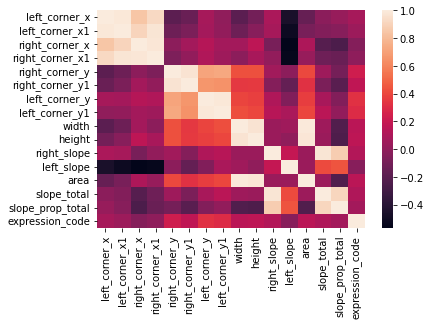

In [21]:
_ = sns.heatmap(img_data_df_new.corr())

In [22]:
x = img_data_df_new[['slope_prop_total']]
y = img_data_df_new[['expression_code']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=20)
x_train

,slope_prop_total
89,0.000003
148,0.000004
0,0.000002
21,0.000006
417,0.000006
...,...
218,0.000008
412,0.000008
223,0.000013
271,0.000010


In [23]:
print("X train shape", x_train.shape)
print("Y train shape", y_train.shape)
print("X test shape", x_test.shape)
print("Y test shape", x_test.shape)

X train shape (322, 1)
Y train shape (322, 1)
X test shape (108, 1)
Y test shape (108, 1)


In [24]:
rModel = linear_model.LogisticRegression()

In [25]:
# We now want to train the model on our test data.
rModel.fit(x_train, y_train)

/home/mgfos207/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [26]:
# Evaluate the model  
rModel.score(x_train, y_train)

0.7919254658385093

In [27]:
y_pred = rModel.predict(x_test)

*~80% Accuracy is not bad let's see if adding a constant to the x training to see if it improves the accuracy, pretty good for using a derived value of the slope of the corner of the mouths*